## Model continuous population variables as a multidimensional Gaussian distribution

The goal of this notebook is to qualitatively examine if the accumulation of all person-years from a Microsim NHANES simulation can be modeled as a multidimensional Gaussian (for each combination of population categorical variables). If this turns out to be a reasonable assumption, then perhaps other populations can be modeled in the same way. In this notebook, the multidimensional distribution information is exported to files and read again from the files to indicate how one may work with them.

In [1]:
import os
import copy
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import multivariate_normal

microsimDir = "/Users/deligkaris.1/OneDrive - The Ohio State University Wexner Medical Center/MICROSIM"
dataDir = microsimDir+"/NOTEBOOKS/DATA"

#contains person-year information from a Microsim NHANES simulation
df = pd.read_csv(dataDir+"/nhanes-normality-test.csv")

In [2]:
#I will use these to separate the person-years in blocks
#an example of block: gender=female, smokingStatus=Never, raceEthnicity=white, statin=True
#note that in the notebook I use integers to represent categories for gender, smokingStatus and raceEthnicity
categoricalVars = ["gender", "smokingStatus", "raceEthnicity", "statin"]

In [3]:
#These are my continuous variables, their order in the list is important
#means will be written in this order and the covariance matrix will also have columns and rows in the same order
continuousVars = ["age","sbp","dbp","bmi"]

In [48]:
#These are set for a qualitative examination of the assumption that the continuous variables can be 
#modeled as a Gaussian
var1 = 0  #var1 and var2 are the two continuous variables I will examine visually
var2 = 3
var3 = 1  #var3 and var4 are the two continuous variables I will set to a fixed value in order to get the 2d 
var4 = 2  #representation of var1 and var2, see below as well....

In [27]:
levels = np.arange(10**(-124), 10**(-125), 10**(-125))

These are the 2D histograms of the var1, var2 pair, using all values for var3 and var4. These do not need to look like
a histogram from a 2D normal distribution but they would need to be a single piece...the reason being that I am using all points of var3 and var4, hence I am essentially projecting the 4D distribution of var1, var2, var3, var4 on the 2D
space of var3 and var4. Summary: so long as these 2D histograms form a single continuous piece, we can move on.

In [ ]:
fig, axes = plt.subplots(30, 2, figsize=(8, 80))
plt.subplots_adjust(hspace=0.6)
print(f"Creating 2d histograms for {continuousVars[var1]} and {continuousVars[var2]} for all blocks...")
for j,gender in enumerate(set(df["gender"].tolist())):
    i=-1
    for smoking in set(df["smokingStatus"].tolist()):
        for raceEthnicity in set(df["raceEthnicity"].tolist()):
            for statin in set(df["statin"].tolist()):
                i+=1
                data = np.array(df.loc[(df["gender"]==gender) & 
                                       (df["smokingStatus"]==smoking) &
                                       (df["raceEthnicity"]==raceEthnicity) &
                                       (df["statin"]==statin),continuousVars].copy())
                list1 = data[:,var1]
                list2 = data[:,var2]
                axes[i,j].hist2d(list1, list2, bins=18)
                axes[i,j].set_title(f"gender={gender},smoking={smoking},raceEthnicity={raceEthnicity},statin={statin}"
                                   ,fontsize=9)
                axes[i,j].set_xlabel(continuousVars[var1])
                axes[i,j].set_ylabel(continuousVars[var2])
#plt.tight_layout()
plt.show()

These are 2D scatter plots of var1 and var2, again, for all values of var3 and var4. Qualitatively, these should be similar to the 2D histograms above, through the use of the alpha parameter in the scatter plot. At this point, the lines on the plots that suggest a lot more points (darker straight lines) or a lot less points (white straight lines) have
an unclear to me origin. These darker/whiter straight lines seem to be related to "age".

In [ ]:
fig, axes = plt.subplots(30, 2, figsize=(8, 80))
plt.subplots_adjust(hspace=0.6)
print(f"Creating scatter plots for {continuousVars[var1]} and {continuousVars[var2]} for all blocks...")
for j,gender in enumerate(set(df["gender"].tolist())):
    i=-1
    for smoking in set(df["smokingStatus"].tolist()):
        for raceEthnicity in set(df["raceEthnicity"].tolist()):
            for statin in set(df["statin"].tolist()):
                i+=1
                data = np.array(df.loc[(df["gender"]==gender) & 
                                       (df["smokingStatus"]==smoking) &
                                       (df["raceEthnicity"]==raceEthnicity) &
                                       (df["statin"]==statin),["age","sbp","dbp","bmi"]].copy())
                list1 = data[:,var1]
                list2 = data[:,var2]
                axes[i,j].scatter(list1, list2, color='black', marker='+', s=1, alpha=0.25,label="nhanes")
                axes[i,j].set_title(f"gender={gender},smoking={smoking},raceEthnicity={raceEthnicity},statin={statin}"
                                   ,fontsize=9)
                axes[i,j].set_xlabel(continuousVars[var1])
                axes[i,j].set_ylabel(continuousVars[var2])
#plt.tight_layout()
plt.show()

These are 2D scatter plots as above (with a smaller alpha value though). Here I am fitting a 2D normal distribution to get an idea (I am showing contours of the Gaussian I get from the fit). 

In [ ]:
fig, axes = plt.subplots(30, 2, figsize=(8, 80))
plt.subplots_adjust(hspace=0.6)
print(f"Creating scatter and contour plots for {continuousVars[var1]} and {continuousVars[var2]} for all blocks...")
for j,gender in enumerate(set(df["gender"].tolist())):
    i=-1
    for smoking in set(df["smokingStatus"].tolist()):
        for raceEthnicity in set(df["raceEthnicity"].tolist()):
            for statin in set(df["statin"].tolist()):
                i+=1
                data = np.array(df.loc[(df["gender"]==gender) & 
                                       (df["smokingStatus"]==smoking) &
                                       (df["raceEthnicity"]==raceEthnicity) &
                                       (df["statin"]==statin),["age","sbp","dbp","bmi"]].copy())
                list1 = data[:,var1]
                list2 = data[:,var2]
                
                distMean, distCov = multivariate_normal.fit(data[:,[var1,var2]])
                dist = multivariate_normal(distMean, distCov)
                gridSize = 200
                x, y = np.meshgrid(np.linspace(min(list1), max(list1), gridSize), 
                                   np.linspace(min(list2), max(list2), gridSize))
                z = dist.pdf(np.dstack([x, y]))
                axes[i,j].contour(x, y, z) 
                axes[i,j].scatter(list1, list2, color='black', marker='+', s=1, alpha=0.05,label="nhanes")
                axes[i,j].set_title(f"gender={gender},smoking={smoking},raceEthnicity={raceEthnicity},statin={statin}"
                                   ,fontsize=9)
                axes[i,j].set_xlabel(continuousVars[var1])
                axes[i,j].set_ylabel(continuousVars[var2])
#plt.tight_layout()
plt.show()

In these plots I fit a 4D normal on all continuous variables. From that fit, I plot the contours at the slice of
the mean of var3 and the mean of var4. I also include as a scatter plot the points that are a set percentage of
the standard deviation from the mean, for both var3 and var4 (essentially I take a thick slice of the 4D scatter plot
and project it to the var1, var2 2D space). This plot should show that the fit includes most of the points...

Creating scatter and contour plots for age and bmi for all blocks...


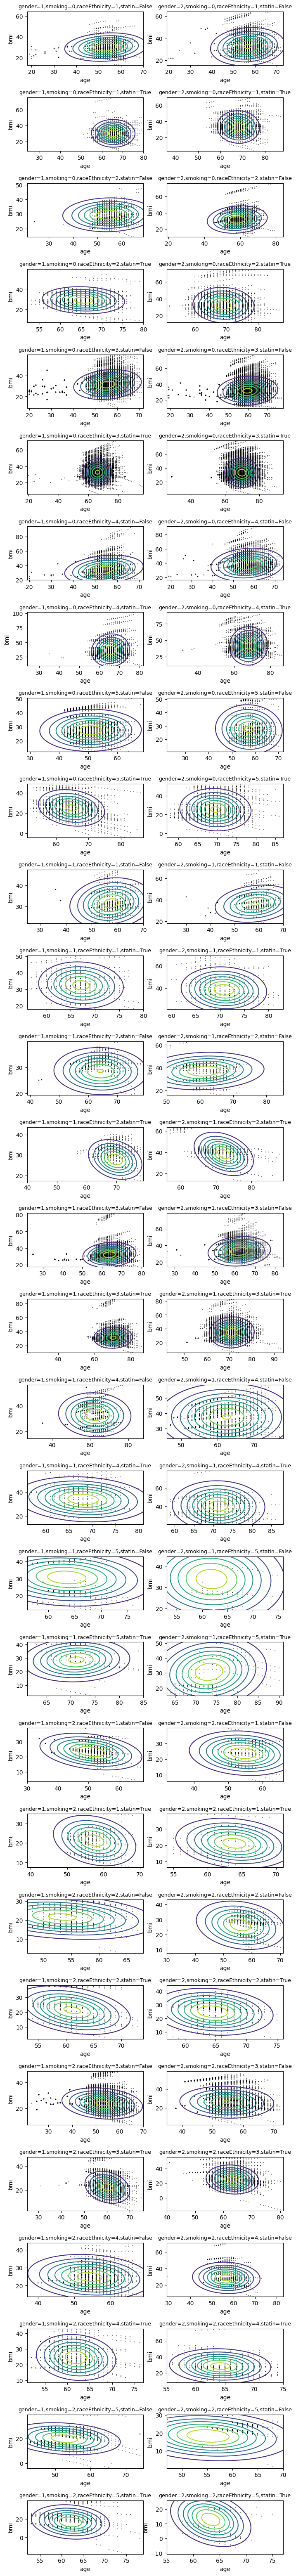

In [58]:
fig, axes = plt.subplots(30, 2, figsize=(8, 80))
plt.subplots_adjust(hspace=0.6)
print(f"Creating scatter and contour plots for {continuousVars[var1]} and {continuousVars[var2]} for all blocks...")
for j,gender in enumerate(set(df["gender"].tolist())):
    i=-1
    for smoking in set(df["smokingStatus"].tolist()):
        for raceEthnicity in set(df["raceEthnicity"].tolist()):
            for statin in set(df["statin"].tolist()):
                i+=1
                #keep the data only for the specific categories
                data = np.array(df.loc[(df["gender"]==gender) & 
                                       (df["smokingStatus"]==smoking) &
                                       (df["raceEthnicity"]==raceEthnicity) &
                                       (df["statin"]==statin),continuousVars].copy())
                
                #get the mean, sd of var3, var4 to determine slice thickness later
                var3Mean = np.mean(data[:,var3])
                var4Mean = np.mean(data[:,var4])
                var3SD = np.std(data[:,var3])
                var4SD = np.std(data[:,var4])
                
                #thickness of slice for the points included in the scatter plot
                dataSliceCondition = ((data[:,var3]>var3Mean-0.25*var3SD) & (data[:,var3]<var3Mean+0.25*var3SD) & 
                                      (data[:,var4]>var4Mean-0.25*var4SD) & (data[:,var4]<var4Mean+0.25*var4SD))
                
                #coordinates of the points included in the scatter plot
                list1=data[ dataSliceCondition, var1]
                list2=data[ dataSliceCondition, var2]
                
                #fit all data
                distMean, distCov = multivariate_normal.fit(data)
                dist = multivariate_normal(distMean, distCov)
                
                #make the grid for the visualization
                gridSize = 200
                x, y = np.meshgrid(np.linspace(min(list1), max(list1), gridSize), 
                                   np.linspace(min(list2), max(list2), gridSize))
                #x, y = np.meshgrid(np.linspace(min(data[:,var1]), max(data[:,var1]), gridSize), 
                #                   np.linspace(min(data[:,var2]), max(data[:,var2]), gridSize))
                
                #set the var3 and var4 values used to make the 2D var1 and var2 contours
                var3Array = np.ones(x.shape)*var3Mean - 0 * np.ones(x.shape)*var3SD
                var4Array = np.ones(x.shape)*var4Mean - 0 * np.ones(x.shape)*var4SD
                
                #put the 4D coordinates in the right order
                coordinates = [None,None,None,None]
                coordinates[var1]=x
                coordinates[var2]=y
                coordinates[var3]=var3Array
                coordinates[var4]=var4Array
                
                #get the PDF
                z = dist.pdf(np.dstack(coordinates))
                
                axes[i,j].contour(x, y, z)#,levels)
                axes[i,j].scatter(list1, list2, color='black', marker='+', s=1, alpha=0.5,label="nhanes")
                axes[i,j].set_title(f"gender={gender},smoking={smoking},raceEthnicity={raceEthnicity},statin={statin}"
                                   ,fontsize=9)
                axes[i,j].set_xlabel(continuousVars[var1])
                axes[i,j].set_ylabel(continuousVars[var2])
                
#plt.tight_layout()
plt.show()

Below, I am exporting the 4D normal distributions for each block. For each distribution, the mean array should be 4x1, and the covariance array should be 4x4. I export all mean arrays to a single file and all covariance arrays to a different single file. For each array I include the categorical variable information in order to know for which block the array corresponds to. 

In [100]:
print("Exporting files...")
with open(dataDir+"/nhanesMeans.csv", "w") as meansFile, open(dataDir+"/nhanesCovs.csv","w") as covsFile:
    pd.DataFrame(categoricalVars+continuousVars).T.to_csv(meansFile, header=True, index=False)
    pd.DataFrame(categoricalVars+continuousVars).T.to_csv(covsFile, header=True, index=False)
    for j,gender in enumerate(set(df["gender"].tolist())):
        i=-1
        for smoking in set(df["smokingStatus"].tolist()):
            for raceEthnicity in set(df["raceEthnicity"].tolist()):
                for statin in set(df["statin"].tolist()):
                    i+=1
                    data = np.array(df.loc[(df["gender"]==gender) & 
                                           (df["smokingStatus"]==smoking) &
                                           (df["raceEthnicity"]==raceEthnicity) &
                                           (df["statin"]==statin),["age","sbp","dbp","bmi"]].copy())
                
                    distMean, distCov = multivariate_normal.fit(data)
                    
                    #columns 0 to 3 are the values (or categories) of the categorical variables
                    #columns 4 to 7 are the means of the continuous variables
                    #1 row per block because means are of shape (1,4)
                    distMeanDf = pd.DataFrame(distMean)
                    pd.concat(
                        [ pd.DataFrame([gender, smoking, raceEthnicity, statin]).T,
                          distMeanDf.T],axis=1, ignore_index=True).to_csv(meansFile, header=False, index=False)
                    meansFile.write("\n\n")
                    
                    #columns 0 to 3 are the values (or categories) of the categorical variables
                    #columns 4 to 7 are the covs of the continuous variables
                    #4 rows per block because covs are of shape (4,4)
                    distCovDf = pd.DataFrame(distCov)
                    pd.concat(
                        [ pd.concat([pd.DataFrame([gender, smoking, raceEthnicity, statin]).T]*len(continuousVars),ignore_index=True),
                          distCovDf.T],axis=1, ignore_index=True).to_csv(covsFile, header=False, index=False)
                    covsFile.write("\n\n")
print("Done")             

Exporting files...
Done


Below, I am reading the two CSV files I just exported with the means and the covariance arrays.

In [104]:
meansDf = pd.read_csv(dataDir+"/nhanesMeans.csv", header=1)
covsDf = pd.read_csv(dataDir+"/nhanesCovs.csv", header=1)

In [109]:
meansDf.head(2)

,gender,smokingStatus,raceEthnicity,statin,age,sbp,dbp,bmi
0,1,0,1,False,53.109023,128.644268,83.709392,30.136067
1,1,0,1,True,65.466822,128.700033,77.598679,30.177500


In [115]:
#how to get the 1x4 means array for a specific block
meansDf.loc[ (meansDf["gender"]==1) &
             (meansDf["smokingStatus"]==0) &
             (meansDf["raceEthnicity"]==1) &
             (meansDf["statin"]==False), continuousVars]

,age,sbp,dbp,bmi
0,53.109023,128.644268,83.709392,30.136067


In [108]:
covsDf.head(8)

,gender,smokingStatus,raceEthnicity,statin,age,sbp,dbp,bmi
0,1,0,1,False,316.793054,-4.683291,-162.071942,29.315486
1,1,0,1,False,-4.683291,184.928510,95.655132,2.729138
2,1,0,1,False,-162.071942,95.655132,160.098437,-12.971982
3,1,0,1,False,29.315486,2.729138,-12.971982,49.939111
4,1,0,1,True,259.384426,-88.481590,-178.340320,6.971460
5,1,0,1,True,-88.481590,194.822657,126.992958,10.462631
6,1,0,1,True,-178.340320,126.992958,158.319821,-0.789528
7,1,0,1,True,6.971460,10.462631,-0.789528,75.387332


In [114]:
#how to get the 4x4 cov array for a specific block
covsDf.loc[ (covsDf["gender"]==1) &
            (covsDf["smokingStatus"]==0) &
            (covsDf["raceEthnicity"]==1) &
            (covsDf["statin"]==False), continuousVars]

,age,sbp,dbp,bmi
0,316.793054,-4.683291,-162.071942,29.315486
1,-4.683291,184.928510,95.655132,2.729138
2,-162.071942,95.655132,160.098437,-12.971982
3,29.315486,2.729138,-12.971982,49.939111
